In [86]:
# Data management
import pandas as pd

# Data preprocessing and trasformation (ETL)
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, IterativeImputer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, MaxAbsScaler, FunctionTransformer, Binarizer, OneHotEncoder, OrdinalEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

# Math and Stat modules
import numpy as np
from scipy.stats import sem

# Supervised Learning
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict, KFold, StratifiedKFold, RepeatedKFold, ShuffleSplit, StratifiedShuffleSplit
from sklearn.linear_model import Perceptron, LogisticRegression
from sklearn.base import BaseEstimator
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, precision_recall_curve, roc_curve
from sklearn.dummy import DummyClassifier

# Unsupervised Learning

# Visualization
import matplotlib.pyplot as plt

%matplotlib inline

Prepariamo velocemente i dati

In [2]:
credit_card_data = pd.read_csv('BankChurnersMissingData.csv')
credit_card_data.dropna(subset=['Total_Revolving_Bal','Months_Inactive_12_mon'],
                   inplace=True
                  )

# Estraggo la  colonna delle label e la rimuovo dal dataset
credit_card_label = credit_card_data['Attrition_Flag'].map(
    {'Existing Customer':0,
     'Attrited Customer':1
    }
).values
credit_card_data.drop(columns=['Attrition_Flag',
                               'CLIENTNUM',
                               'Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_2',
                               'Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_1'],
                      inplace=True)

In [3]:
def unknown_imputer(X, missing_value = 'Unknown'):
    X = X.values
    unique_values, count = np.unique(X,return_counts=True)
    num_nan = count[unique_values == missing_value]
    counting = count[unique_values != missing_value]
    values = unique_values[unique_values != missing_value]
    X_new = X.copy()
    freq = counting / np.sum(counting)
    X_new[X_new == missing_value] = np.random.choice(values,size=num_nan,p=freq)
    return X_new

ui = FunctionTransformer(unknown_imputer)

customer_age_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

category_pipeline = Pipeline([
    ('imputer', FunctionTransformer(unknown_imputer)),
    ('ordinal', OneHotEncoder())
])

features_robust = ['Credit_Limit','Total_Revolving_Bal','Avg_Open_To_Buy']
features_standard = list(set(credit_card_data.select_dtypes(include=['int64','float64']).columns).difference(set(features_robust + ['Avg_Utilization_Ratio', 'Customer_Age'])))

In [4]:
data_preprocessing = ColumnTransformer([
    ('age', customer_age_pipeline, ['Customer_Age']),
    ('gender', OrdinalEncoder(categories=[['M','F']]), ['Gender']),
    ('edu', category_pipeline, ['Education_Level']),
    ('status', category_pipeline, ['Marital_Status']),
    ('income', category_pipeline, ['Income_Category']),
    ('card', category_pipeline, ['Card_Category']),
    ('numeric_robust', RobustScaler(), features_robust),
    ('feature_standard', StandardScaler(), features_standard)
],
    remainder = 'passthrough'
)

In [5]:
feature_matrix = data_preprocessing.fit_transform(credit_card_data)

In [6]:
columns_name = ['Customer_Age','Gender']
for c in ['Education_Level','Marital_Status','Income_Category']:
    cat_inc_name = [c+'_cat{}'.format(i) for i in range(1,len(credit_card_data[c].unique()))]
    columns_name.extend(cat_inc_name)
columns_name.extend(['Card_Category_cat{}'.format(i) for i in range(1,len(credit_card_data['Card_Category'].unique())+1)])
columns_name.extend(features_robust)
columns_name.extend(features_standard)
columns_name.append('Avg_Utilization_Ratio')

# Classificazione

Ora siamo pronti per addestrare un modello ML e lo potremmo fare piuttosto facilmente grazie al fatto che abbiamo gia' preparato i dati e alla struttura di SKL.

Iniziamo ad addestrare un Perceptron.

In [19]:
perceptron = Perceptron()
perceptron.fit(feature_matrix, credit_card_label)

Perceptron()

Vediamo come si comporta con alcuni elementi del training set.

In [20]:
sample_training = feature_matrix[:10,:]
sample_labels = credit_card_label[:10]
prediction_sample = perceptron.predict(sample_training)
for i in range(len(sample_labels)):
    print(i,'True label: {} vs Predicted Label: {}'.format(sample_labels[i],prediction_sample[i]))

0 True label: 0 vs Predicted Label: 0
1 True label: 0 vs Predicted Label: 0
2 True label: 0 vs Predicted Label: 0
3 True label: 0 vs Predicted Label: 0
4 True label: 0 vs Predicted Label: 0
5 True label: 0 vs Predicted Label: 0
6 True label: 0 vs Predicted Label: 0
7 True label: 0 vs Predicted Label: 0
8 True label: 0 vs Predicted Label: 0
9 True label: 0 vs Predicted Label: 0


Un risultato che potrebbe sembrare incoraggiante...

Proviamo a contare quante volte sbaglio su un set di dati gia' visto...

E' fondamentale, infatti, determinare/stimare le performance del modello su un insieme di dati mai visto prima. In precedenza non abbiamo 

In [21]:
all_predicted = perceptron.predict(feature_matrix)

In [22]:
np.sum(all_predicted == credit_card_label)/len(all_predicted)

0.8574814814814815

Non sembra male, ma ...

In [23]:
all_predicted_dummy = np.zeros(len(credit_card_label))
np.sum(all_predicted_dummy == credit_card_label)/len(all_predicted_dummy)

0.8393086419753086

Il perceptron performance un po' meglio di un modello "in tilt",i.e un modello che predice sempre la classe piu' frequente.

Questa piccola differenza di performance ci permette di introdurre alcune trappole in cui siamo caduti. 
1) La valutazione delle performance deve essere effettuata su dati non ancora 'visti' dall'algoritmo di apprendimento (errore metodologico)
2) La valutazione deve tenere conto del bilanciamento o meno delle classi

In questa fase, esploriamo il **primo** problema.

## Cross-validation
Le metodologie di cross-validation possono essere utili per ottenere delle valutazioni piu' attendibili circa le proprieta' di generalizzazione del modello appreso, cioe' quanto il modello sara' in grado di predirre correttamente la classe di appartenenza su dati non ancora osservati.

Per prevenire il primo errore, e  di conseguenza l'overfitting dei dati, una pratica comune e' **holdout cross validation**. Si divide il dataset in due insiemi distinti: training e test dataset. Il primo e' usato per l'addestramento del modello, il secondo per la valutazione delle performance. 

Un raffinamento del precedente schema e' l'utilizzo di un terzo insieme: **validation set**, grazie al quale viene fatto una model selection, i.e. vengono identificati l'insieme degli iperparametri attuali. In questo modo ho il vantaggio di non utilizzare il test set nella fase di learning riducendo il bias sulla stima della capacita' di generalizzare su nuovi dati.

Il modo in cui gli insiemi vengono partizionati influenza la stima delle performance. Per aumentare la robustezza della stima possiamo utilizzare **k-fold cross validation**. Inoltre, la suddivisione in 3 insiemi 

Prima, pero', vediamo come fare holdout cross-validation in SKL. SKL mette a disposizione il metodo **train_test_split** che mi restituisce una partizione in training e test sia della matrice delle feature sia del vettore delle label. E' possibile specificare la frazione di elementi che costituiscono i due insiemi.

Nel nostro caso, il training set e' costituito dal 70% del campione.

In [12]:
X_train, X_test, y_train, y_test = train_test_split(feature_matrix, credit_card_label, test_size=0.3, random_state=0)

In [24]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((7087, 33), (7087,), (3038, 33), (3038,))

In [25]:
perceptron.fit(feature_matrix, credit_card_label)
predicted_test = perceptron.predict(X_test)
np.sum(predicted_test == y_test)/len(y_test)

0.8489137590520079

Nella k-fold cross-validatin - k-fold CV - il training set viene suddiviso in $k$ sottoinsiemi disgiunti - *fold* , dove ogni fold:
1) i rimanenti $k-1$ fold sono utilizzati come training set
2) il modello addestrato sui $k-1$ fold viene valutato sulla parte rimanente del dataset.

In questo modo si ottengono $k$ modelli e $k$ misure di performance diverse. Si calcola, quindi una media delle performance. Una volta selezionato l'insieme degli iperparametri migliori, si riaddestra il modello sul training set completo e si effettua la valutazione del test set.

![](kfold-cross_validation.png)

Attraverso il metodo **cross_val_score** possiamo usare direttamente k-CV e ottenere le misure di performance per ogni fold.

Solitamente come valore da assegnare a $k$ si usa 5 o 10, a seconda della dimensione del dataset. In SKL, se $K$ e' un intero vengono utilizzate le classi **KFold** o **StratifiedKFold**, come strategie di partizionamento di default.

In [26]:
perceptron_score = cross_val_score(perceptron, X_train, y_train, cv = 10)
perceptron_score

array([0.86600846, 0.8787024 , 0.85472496, 0.87023977, 0.82510578,
       0.85190409, 0.88716502, 0.87853107, 0.8559322 , 0.88700565])

In [27]:
'Accuracy media: {:0.3f}'.format(np.mean(perceptron_score))

'Accuracy media: 0.866'

Approfondiremo le misure di performance in seguito.

Come vedremo il parametro **cv** ammette tipo di dato diverso, in modo da specificare quale strategia di divisione del set utilizzare in forma di classi SKL o iterable su un insieme di indici.

Una funzione simile a *cross_val_score* e' **cross_val_predict**. Restituisce per ogni elemento nel training set, la label predetta quando quell'elemento era nel fold di test.

In [28]:
predicted_in_fold = cross_val_predict(perceptron, X_train, y_train, cv = 5)

### Cross Validation Itertors
La generazione delle fold dipende fortemente dal meto di partizionamento/campionamento adottato e dalle assunzioni sul tipo di dato presente nel dataset.

Se assumiamo che i dati siano i.i.d.  - indipendenti e identicamente distribuiti - il processo generativo dei dati e' uno e non ha memoria dei dati generati in passato. In questo caso possiamo utilizzare:
- k-fold
- Repeated k-fold
- LOO
- LPO
- Shuffle and Split

La classe **KFold** implementa il k-fold splitting della k-fold CV. Vedi https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html#sklearn.model_selection.KFold

In [36]:
kf = KFold(n_splits = 10)
perceptron_score = cross_val_score(perceptron, X_train, y_train, cv = kf)
perceptron_score

array([0.89844852, 0.88434415, 0.87165021, 0.85472496, 0.86318759,
       0.85472496, 0.88152327, 0.87288136, 0.88559322, 0.92090395])

Mediante il metodo **split** posso ottenere l'insieme dei fold di training e il fold di test, espressi come indici della feature matrix. In sostanza indica quali righe inserire nel fold di training e quali inseire nel fold di test.

In [39]:
for train, test in kf.split(X_train, y_train):
    print(X_train[train,:].shape, y_train[test].shape)

(6378, 33) (709,)
(6378, 33) (709,)
(6378, 33) (709,)
(6378, 33) (709,)
(6378, 33) (709,)
(6378, 33) (709,)
(6378, 33) (709,)
(6379, 33) (708,)
(6379, 33) (708,)
(6379, 33) (708,)


Possiamo notare come nell'esempio precedente sul perceptron, i valori di performance possono oscillare ed influenzare la performance media. 

Una soluzione per ridurre l'effetto delle oscillazioni nel calcolo della performance media e' ripetere la k-fold CV per diverse volte e riportare la performance media calcolata su tutti i fold di tutte le ripetizioni. Ovviamente, il partizionamento tra due ripetizioni non e' lo stesso.<br>
Questo approccio e' utile con dataset di piccola/media dimensione e che non richiedono un elevato costo di computazione nella fase di training, anche se e' facile parallelizzare il processo (SKL lo fa di default)

SKL fornisce un'implementazione di tale metodo mediante la classe **RepeatedKFold** (https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RepeatedKFold.html#sklearn.model_selection.RepeatedKFold). Si devono specificare i valori di $K$ e il numero di ripetizioni *n_repeats*.

In [45]:
rkf = RepeatedKFold(n_splits = 10, n_repeats=3)
perceptron_score = cross_val_score(perceptron, X_train, y_train, cv = rkf, n_jobs=-1)
perceptron_score

array([0.8448519 , 0.85895628, 0.8787024 , 0.88293371, 0.8899859 ,
       0.79689704, 0.85331453, 0.82768362, 0.87711864, 0.8940678 ,
       0.89562764, 0.85895628, 0.87729196, 0.89139633, 0.86882934,
       0.87306065, 0.89703808, 0.89689266, 0.87288136, 0.89265537,
       0.88857546, 0.87588152, 0.88152327, 0.83638928, 0.87447109,
       0.87447109, 0.88575458, 0.87570621, 0.76412429, 0.87146893])

Da notare il parametro *n_jobs* tramite cui specifico quanti core utilizzare in parallelo per eseguire CV.

E' possibile anche valutare l'effetto del numero di ripetizioni sulle performance medie del classificatore.

>1 mean=0.8628 se=0.007
>2 mean=0.8612 se=0.005
>3 mean=0.8619 se=0.004
>4 mean=0.8614 se=0.003
>5 mean=0.8635 se=0.003
>6 mean=0.8611 se=0.003
>7 mean=0.8588 se=0.003
>8 mean=0.8578 se=0.003
>9 mean=0.8587 se=0.003
>10 mean=0.8592 se=0.003
>11 mean=0.8601 se=0.003
>12 mean=0.8608 se=0.002
>13 mean=0.8612 se=0.002
>14 mean=0.8607 se=0.002
>15 mean=0.8612 se=0.002


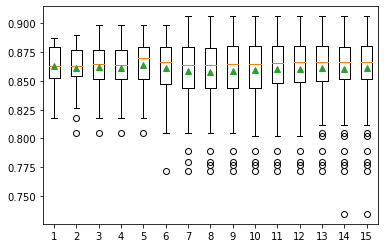

In [51]:
def valuta_modello_ripetizione(X, y, repeats):
    cv = RepeatedKFold(n_splits=10, n_repeats=repeats, random_state=1)
    model = Perceptron()
    scores = cross_val_score(model, X, y, cv=cv, n_jobs=-1)
    return scores

repeats = range(1,16)
results = list()
for r in repeats:
    scores = valuta_modello_ripetizione(feature_matrix, credit_card_label, r)
    print('>{} mean={:.4f} se={:.3f}'.format(r, np.mean(scores), sem(scores)))
    results.append(scores)
# plot the results
plt.boxplot(results, labels=[str(r) for r in repeats], showmeans=True)
plt.show()

Sempre nel setting iid, possiamo generare un insieme di split training/test in cui viene violata la condizione di insieme disgiunto tra le fold. In questo caso appliciamo una random permutation CV.

In SKL tale strategia e' fornita dalla classe **ShuffleSplit**. Per ogni iterazione - splitting, la feature matrix viene permutata e una sua frazione di righe viene assegnata al test set.

In [53]:
spf = ShuffleSplit(n_splits = 10, test_size = 0.25)
perceptron_score = cross_val_score(perceptron, X_train, y_train, cv = rkf, n_jobs=-1)
perceptron_score.mean()

0.8664674523678612

In questo modo si ha un controllo maggiore sulla porzione di elementi nel test e si perde la dipendenza tra $k$ e *test_size*

#### Stratification
In alcuna situazione assistiamo - come nel nostro caso - ad un forrte sbilanciamento nella distribuzione delle classi nel vettore delle label. In questi casi si raccomanda di utilizzare un campionamento stratitificato implementato dalle classi SKL **StratifiedKFold** e **StratifiedShuffleSplit**. Tali classi assicurano che la distribuzione delle etichette in ogni fold approssimi quella dell'intero vettore delle etichette

Nel caso di StratifiedKFold avremo la suddivisione in figura:
![](stratified_kfold_cv.png)

In [58]:
kf = KFold(n_splits=10)
skf = StratifiedKFold(n_splits=10)
print('----K-fold CV----------')
for train, test in kf.split(feature_matrix, credit_card_label):
    y_train, y_test = credit_card_label[train], credit_card_label[test]
    print('Train: {:.2f} vs Test: {:.2f}'.format(sum(y_train == 1)/len(y_train), sum(y_test == 1)/len(y_test)))
print('----Stratified K-fold CV-------')
for train, test in skf.split(feature_matrix, credit_card_label):
    y_train, y_test = credit_card_label[train], credit_card_label[test]
    print('Train: {:.2f} vs Test: {:.2f}'.format(sum(y_train == 1)/len(y_train), sum(y_test == 1)/len(y_test)))

----K-fold CV----------
Train: 0.17 vs Test: 0.10
Train: 0.17 vs Test: 0.07
Train: 0.17 vs Test: 0.05
Train: 0.16 vs Test: 0.14
Train: 0.16 vs Test: 0.21
Train: 0.15 vs Test: 0.21
Train: 0.16 vs Test: 0.21
Train: 0.16 vs Test: 0.20
Train: 0.16 vs Test: 0.15
Train: 0.15 vs Test: 0.25
----Stratified K-fold CV-------
Train: 0.16 vs Test: 0.16
Train: 0.16 vs Test: 0.16
Train: 0.16 vs Test: 0.16
Train: 0.16 vs Test: 0.16
Train: 0.16 vs Test: 0.16
Train: 0.16 vs Test: 0.16
Train: 0.16 vs Test: 0.16
Train: 0.16 vs Test: 0.16
Train: 0.16 vs Test: 0.16
Train: 0.16 vs Test: 0.16


Lo stesso principio si applica alla metodologia di shuffle and split:
![](stratified_shufflesplit_cv.png)

## Performance Measure for Classification

Viste le diverse strategie di cross-validation, affrontiamo un secondo argomento essenziale: le misure di performance.

Abbiamo gia' visto che il perceptron utilizzato in precedenza non era meglio di un classificatore che prediceva sempre l'etichetta piu' frequente.

In [56]:
mf_dumb_cls = DummyClassifier(strategy='prior')
uni_dumb_cls = DummyClassifier(strategy='uniform')
st_dumb_cls = DummyClassifier(strategy='stratified')

In [39]:
pappagallo_score = cross_val_score(mf_dumb_cls, X_train, y_train, cv=10, scoring='accuracy')
pappagallo_score.mean()

0.8395657526714638

Cio' mostra come l'accuracy non e' una buona misura di performance, specialmente quando il vettore delle etichette e' sbilanciato.

Un modo migliore per valutare le performance di un classificatore e' la **confusion matrix** $C$. L'elemento $C_{ij}$ della matrice corrisponde al numero di osservazioni che hanno etichetta $i$ e che sono state classificate con etichetta $j$. Nel caso di classificazione binario:
1) $C_{00}$ = veri negativi
2) $C_{01}$ = falsi positivi
3) $C_{10}$ = falsi negativi
4) $C_{11}$ = veri positivi

Per calcolare la confusion matrix, necessitiamo di:
1) il vettore delle etichette
2) il vettore delle etichette predette
Per ottenere il secondo elemento possiamo utilizzare il metodo  *cross_val_predict*

In [33]:
y_train_predicted = cross_val_predict(perceptron, X_train, y_train, cv = 10)

Infine per calcolare la confusion matrix utilizziamo il metodo **confusion matrix**.

In [34]:
confusion_matrix(y_train, y_train_predicted)

array([[5492,  458],
       [ 495,  642]], dtype=int64)

Ogni riga corrisponde ad una classe _attuale_, mentre ogni colonna una _classe predetta_.

Dalla matrice di confusione posso calcolare l'accuratezza delle predizioni positive, i.e. la **precision**:
$$precision = \frac{C_{11}}{C_{11} + C_{01}} = \frac{TP}{TP + FP}$$

a cui si accompagna un'altra metrica: la **recall** o **sensitivity** o **true positive rate**:
$$precision = \frac{C_{11}}{C_{11} + C_{10}} = \frac{TP}{TP + FN}$$

In SKL precision e recall sono restituite dai metodi **precision_score** e **recall_score**

In [35]:
precision_score(y_train, y_train_predicted)

0.5836363636363636

In [36]:
recall_score(y_train, y_train_predicted)

0.5646437994722955

Vediamo le differenze confrontandoci con i due dummy classifier definiti in precedenza

In [57]:
y_train_mfdumb = cross_val_predict(mf_dumb_cls, X_train, y_train, cv = 10)
y_train_unidumb = cross_val_predict(uni_dumb_cls, X_train, y_train, cv = 10)
y_train_stdumb = cross_val_predict(st_dumb_cls, X_train, y_train, cv = 10)

In [58]:
precision_score(y_train,y_train_mfdumb), precision_score(y_train, y_train_unidumb), precision_score(y_train, y_train_stdumb)

C:\Users\matte\miniconda3\envs\CSML21\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


(0.0, 0.165483962531933, 0.1696113074204947)

Nel caso di dummy che predice la singola classe piu' frequente, la colonna nella confusion matrix relativa alla classe 1 e' composta da 0 => 0/0. Nei rimanenti casi, si puo' intuire il risultato se pensiamo al processo di classificazione implementato come una selezione. Nel caso predica 1, seleziono l'elemento del campione e mi chiedo quale sia la sua etichetta. In entrambi i casi vengono rispettate le proporzioni della classe nel campione originario. In un caso seleziono meno elementi (stratified), perche' le etichette sono sbilanciate.

In [59]:
recall_score(y_train,y_train_mfdumb), recall_score(y_train, y_train_unidumb), recall_score(y_train, y_train_stdumb)

(0.0, 0.5127528583992964, 0.16886543535620052)

Nel primo caso la recall e' 0 perche' $C_{11}=0$. Per spiegare i rimanenti risultati, si selezionano i campioni con etichetta vera = 1, nel caso uniforme ottengo il 50% di elementi con etichetta 1, nel caso stratified ottengo solo il 16% con etichetta 1.

In [60]:
confusion_matrix(y_train, y_train_unidumb), confusion_matrix(y_train, y_train_stdumb)

(array([[3010, 2940],
        [ 554,  583]], dtype=int64),
 array([[5010,  940],
        [ 945,  192]], dtype=int64))

Sia in recall che precision, il perceptron si comporta leggermente meglio di un random guesser.

In generale *una soluzione basata su perceptron non e' affidabile nel caso mi segnali un cliente 'in uscita', e neanche in grado di identificare un cliente 'in uscita'*.

Per avere un modo semplice per confrontare due classificatori, viene spesso impiegato l'indicatore $F_{1}$, definito come la media armonica tra precision e recall. Penalizza un classificatore con precision e recall sbilanciate.
$F_1 = \frac{2}{\frac{1}{precision}+\frac{1}{recall}}$. Questo indicatore viene implementato dal metodo **f1_score**

### Precision/Recall Tradeoff
Utilizziamo ora un logit classifier per il problema dell'identificazione dei churner dal momento che restituisce anche un prediction score. Nel caso del classificatore in questione, corrisponde al valore prima della funzione di threshold, i.e. $\phi(\mathbf{w}^T\mathbf{x})$. Esso indica la confidenza sulla classe predetta. In SKL un logit classifier e' implementato dalla classe **LogisticRegression**, il quale rende disponibile il metodo **decision_function** per ottenere gli score di confidenza associati ad ogni istanza predetta.

In questo modo possiamo agire sulla funzione di soglia e modificare la predizione finale.

In [67]:
logit_cls = LogisticRegression(max_iter=1000)
y_scores = cross_val_predict(logit_cls, X_train, y_train, cv = 10, method='decision_function')

Dato gli score, possiamo utilizzare il metodo **precision_recall_curve** per calcolare precision e recall al variare del valori di soglia

In [68]:
prec, rec, soglia = precision_recall_curve(y_train, y_scores)

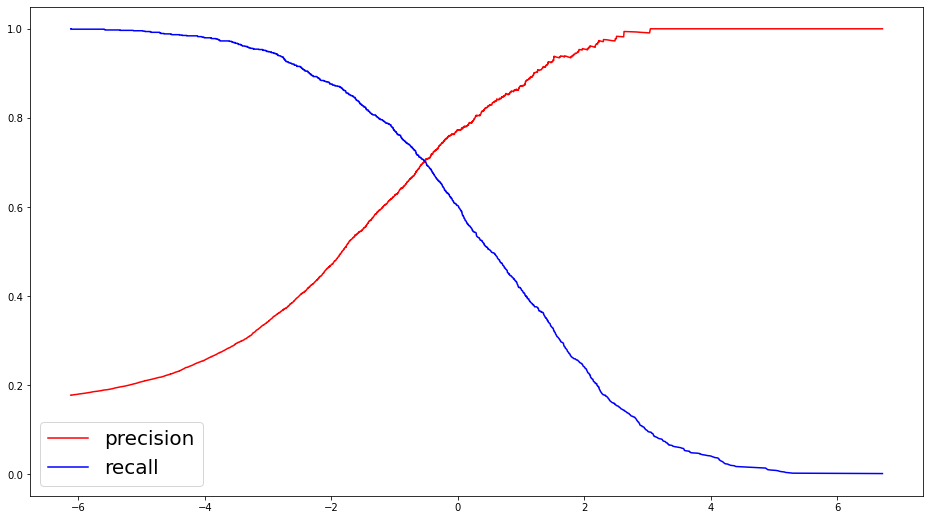

In [79]:
fig = plt.figure(figsize=(16,9))
ax = fig.add_subplot()
ax.plot(soglia, prec[:-1], 'r',label='precision')
ax.plot(soglia, rec[:-1], 'b',label='recall')
ax.legend(fontsize=20)

Oppure posso visualizzare la precision in funzione della recall

Text(0, 0.5, 'precision')

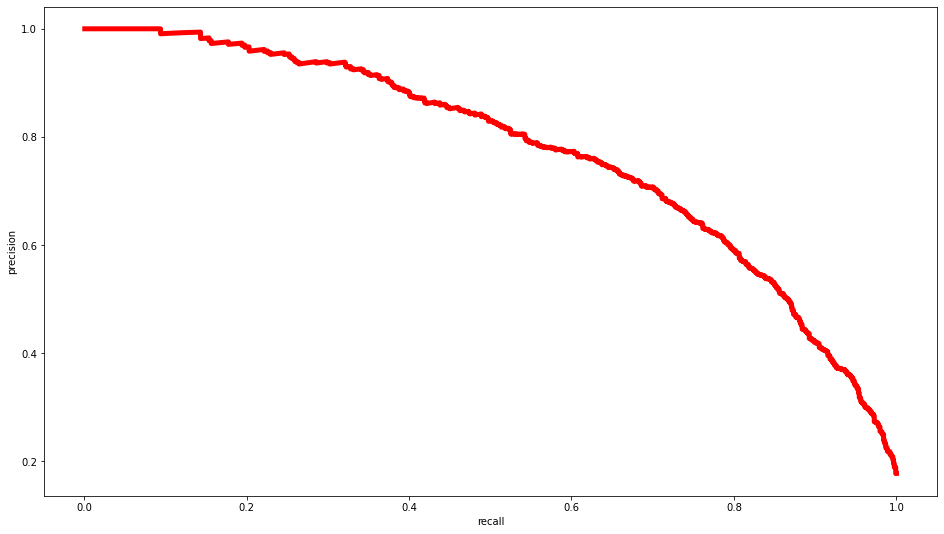

In [82]:
fig = plt.figure(figsize=(16,9))
ax = fig.add_subplot()
ax.plot(rec[:-1], prec[:-1], 'r',label='precision', lw=5)
ax.set_xlabel('recall')
ax.set_ylabel('precision')

Questo tipo di analisi ci permette di scegliere il valore in base alle nostre esigenze. Per esempio se volessimo aumentare la fino a 0.9 ...

In [85]:
soglia_prec_90 = soglia[np.argmax(prec >= 0.9)]
y_train_prec_90 = y_scores >= soglia_prec_90
precision_score(y_train, y_train_prec_90), f1_score(y_train, y_train_prec_90)

(0.9014675052410901, 0.5328376703841388)

### ROC Curve
La curva **Receiver operating characteristic - ROC** e' molto simile alla curva precision/recall ma visualizza la recall in funzione del **false positive rate**:
$$FPR = \frac{C_{01}}{C_{01}+C{00}} = \frac{FP}{FP+TN} = 1 - specificity$$
Per visualizzare la curva ROC applichiamo lo stesso procedimento precedente utilizzo il metodo **roc_curve**.

In [87]:
fpr, rec, soglia = roc_curve(y_train, y_scores)

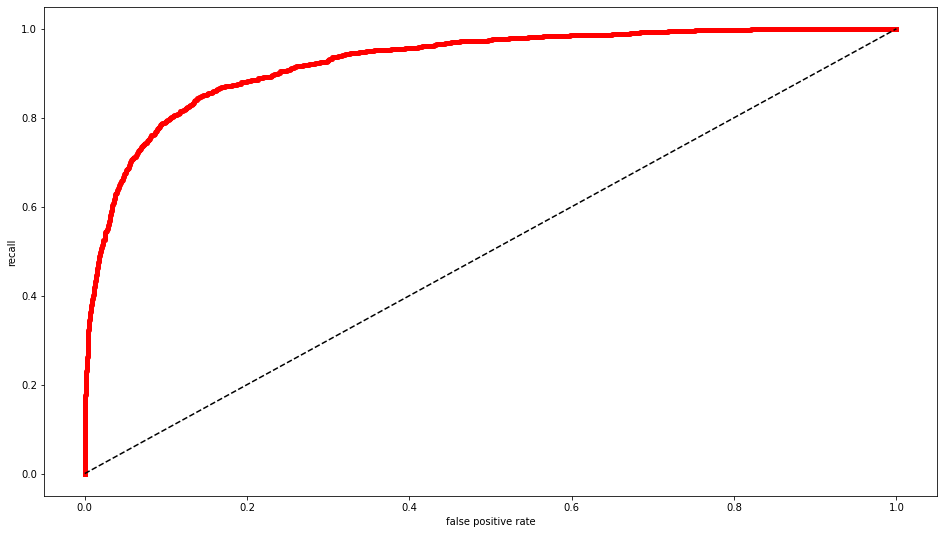

In [91]:
fig = plt.figure(figsize=(16,9))
ax = fig.add_subplot()
ax.plot(fpr, rec, 'r',label='precision', lw=5)
ax.plot()
ax.set_xlabel('false positive rate')
ax.set_ylabel('recall')
ax.plot([0,1],[0,1],'k--')

All'aumentare della recall, aumenta la produzione di falsi positivi.